In [1]:
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

2024-06-18 08:39:52.745333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 08:39:52.803116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 08:39:53.754476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/modrzyk/miniconda3/envs/Manim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as noteb

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/.local/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the 

In [2]:
# Set data directory
directory = "data"
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

data


In [3]:
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images = [
    os.sep.join([root_dir, "ixi", "IXI314-IOP-0889-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI249-Guys-1072-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI609-HH-2600-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI173-HH-1590-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI020-Guys-0700-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI342-Guys-0909-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI134-Guys-0780-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI577-HH-2661-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI066-Guys-0731-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI130-HH-1528-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI607-Guys-1097-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI175-HH-1570-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI385-HH-2078-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI344-Guys-0905-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI409-Guys-0960-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI584-Guys-1129-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI253-HH-1694-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI092-HH-1436-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI574-IOP-1156-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI585-Guys-1130-T1.nii.gz"]),
]

# 2 binary labels for gender classification: man or woman
labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [4]:
if not os.path.isfile(images[0]):
    resource = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    dataset_dir = os.path.join(root_dir, "ixi")
    tarfile_name = f"{dataset_dir}.tar"

    download_and_extract(resource, tarfile_name, dataset_dir, md5)


In [5]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images, labels=labels, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)


<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([3, 1, 96, 96, 96]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.]]) torch.Size([3, 2])


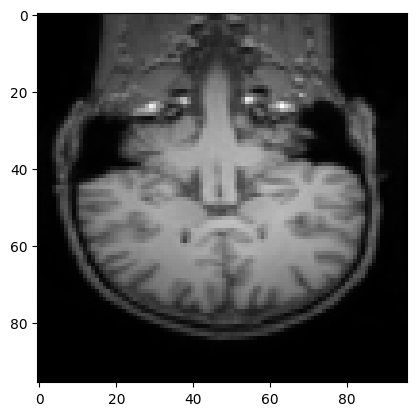

In [6]:
plt.imshow(im[2, 0, 60, :, :].cpu().numpy(), cmap="gray")

In [7]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 20

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/20
1/10, train_loss: 0.6521
2/10, train_loss: 0.7735
3/10, train_loss: 1.4248
4/10, train_loss: 0.6910
5/10, train_loss: 0.7371
6/10, train_loss: 0.7087
7/10, train_loss: 0.8085
8/10, train_loss: 0.7039
9/10, train_loss: 0.6447
10/10, train_loss: 0.7125
epoch 1 average loss: 0.7857
----------
epoch 2/20
1/10, train_loss: 0.6011
2/10, train_loss: 0.8010
3/10, train_loss: 0.6012
4/10, train_loss: 0.5602
5/10, train_loss: 0.6665
6/10, train_loss: 0.5484
7/10, train_loss: 0.6098
8/10, train_loss: 0.5492
9/10, train_loss: 0.6256
10/10, train_loss: 0.5333
epoch 2 average loss: 0.6096
saved new best metric model
Current epoch: 2 current accuracy: 0.6500 
Best accuracy: 0.6500 at epoch 2
----------
epoch 3/20
1/10, train_loss: 0.4881
2/10, train_loss: 0.5236
3/10, train_loss: 0.4676
4/10, train_loss: 0.3074
5/10, train_loss: 0.4808
6/10, train_loss: 0.4318
7/10, train_loss: 1.1117
8/10, train_loss: 0.4236
9/10, train_loss: 0.7236
10/10, train_loss: 0.4806
epoch 3 average los

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# Define U-Net model for classification
class UNetForClassification(nn.Module):
    def __init__(self):
        super(UNetForClassification, self).__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=16,  # You can adjust the number of filters
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
        )
        self.fc = nn.Linear(256 * 12 * 12 * 12, 2)  # Assuming final feature map size is [B, 256, 1, 1, 1]

    def forward(self, x):
        features = self.unet(x)
        latent = features.view(features.size(0), -1)  # Flatten the output
        out = self.fc(latent)
        return out, latent

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetForClassification().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training parameters
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 20

# Function to visualize latent space
def visualize_latent_space(latents, labels, epoch):
    latents = latents.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=0)
    latent_tsne = tsne.fit_transform(latents)
    
    plt.figure(figsize=(8, 6))
    for i in range(2):  # Assuming binary classification
        plt.scatter(latent_tsne[labels == i, 0], latent_tsne[labels == i, 1], label=f"Class {i}")
    plt.legend()
    plt.title(f"Latent Space Visualization at Epoch {epoch}")
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.savefig(f"latent_space_epoch_{epoch}.png")
    plt.show()

# Training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        num_correct = 0.0
        metric_count = 0
        all_latents = []
        all_labels = []

        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs, latents = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()
                all_latents.append(latents)
                all_labels.append(val_labels)

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

        # Concatenate latents and labels and visualize
        all_latents = torch.cat(all_latents)
        all_labels = torch.cat(all_labels)
        visualize_latent_space(all_latents, all_labels, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


----------
epoch 1/20


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x14155776 and 442368x2)

torch.Size([2, 1, 96, 96, 96])


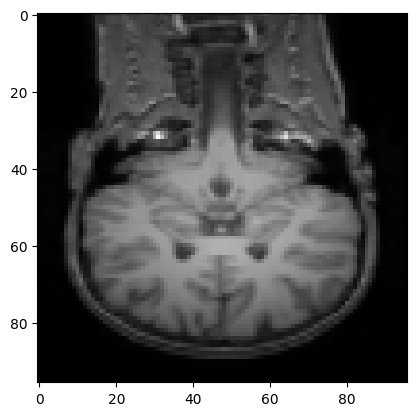

torch.Size([2, 1, 96, 96, 96])


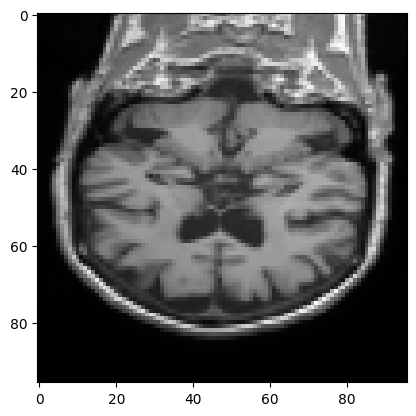

torch.Size([2, 1, 96, 96, 96])


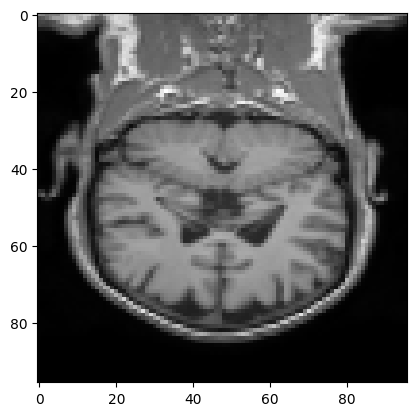

FileNotFoundError: [Errno 2] No such file or directory: 'images/brain2/slice0.png'

In [14]:
for idx, (im, label) in enumerate(train_loader):
    print(im.shape)
    plt.imshow(im[1, 0, 58, :, :].cpu().numpy(), cmap="gray")
    plt.show()
    for i in range(im.shape[2]):
        plt.imsave(f"images/brain{idx}/slice{i}.png", im[1, 0, i, :, :].cpu().numpy(), cmap="gray")

In [19]:
print(len(train_loader))

10
